In [3]:
from google.colab import drive
drive.mount('/content/drive')
#%cd "drive/My Drive/IA-LAB7"
%cd "drive/MyDrive/aa/tp7_4"
%pwd

Mounted at /content/drive
/content/drive/MyDrive/aa/tp7_4


'/content/drive/MyDrive/aa/tp7_4'

**Classificação de comboios - o Explainable Abstract Trains Dataset**

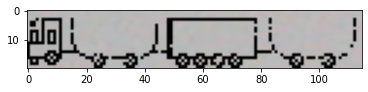
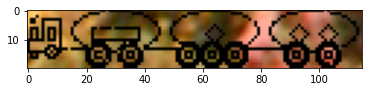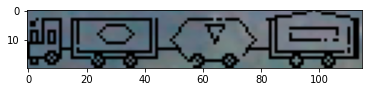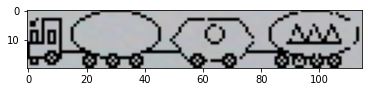

Iremos considerar quatro classes de comboios:

*   EmptyTrain - todas as carruagens estão vazias;
*   HalfFullTrain - algumas carruagens vazias, mas nem todas;
*   FullTrain - todas as carruagens têm exatamente uma figura;
*   OverloadedTrain - não há carruagens vazias e há pelo menos uma carruagem que tem mais do que uma figura.



In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import random

In [5]:
def plot_loss_acc(hist):
  plt.figure()
  plt.plot(hist.history['loss'], label='train_loss')
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.plot(hist.history['accuracy'], label='train_acc')
  plt.plot(hist.history['val_accuracy'], label='val_acc')
  plt.title('Training Loss and Accuracy')
  plt.xlabel('Epoch #')
  plt.ylabel('Loss/Accuracy')
  plt.margins(x=0)
  plt.margins(y=0)
  plt.legend()
  plt.show()

def print_loss_acc(hist):
  dados_finais_de_treino=[(l,hist.history[l][-1]) for l in hist.history]
  print(dados_finais_de_treino)


O seguinte código permite ler e preparar o conjunto de treino e validação:

In [6]:
def _preprocess_images(images):
  # Scale the raw pixel intesities to the range [-1,1]
  images = images / 127.5 # 255/2
  images = images - 1.0
  images.astype(np.float32)
  return images

# Start by loading the training dataset
# The dataset is made of pictures and their labels (EmptyTrain, HalfFullTrain, FullTrain, OverloadedTrain)
training_data_labels_frame = pd.read_csv('training_trains_labels.csv')
data_labels = training_data_labels_frame.columns.values[1:]
training_data_labels = training_data_labels_frame[data_labels].to_numpy()
original_training_data_images = np.load('training_images.npz')['images']
training_data_images = _preprocess_images(original_training_data_images)

# Load the validation dataset
validation_data_labels_frame = pd.read_csv('validation_trains_labels.csv')
validation_data_labels = validation_data_labels_frame[data_labels].to_numpy()
validation_data_images = _preprocess_images(np.load('validation_images.npz')['images'])

y_t_cats = to_categorical(training_data_labels,num_classes=4)
y_v_cats = to_categorical(validation_data_labels,num_classes=4)

Depois desta leitura e pre-processamento dos dados, os pares **(training_data_images,training_data_labels)** e **(validation_data_images,validation_data_labels)** contêm o conjunto de treino e validação, respetivamente.


Podemos visualizar um pouco mais de informação sobre o dataset usando o seguinte código:

Image data shape: (1200, 20, 115, 3)
Data labels: ['Empty' 'HalfFull' 'Full' 'Overloaded']


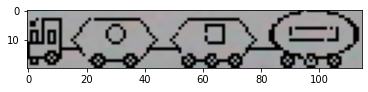

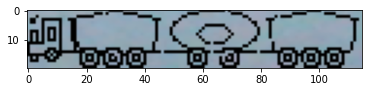

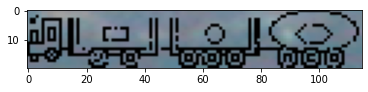

In [7]:
# Lets explore our training dataset
# Print the shape of the training images (#images, height, width, #channels)
# Note: Each channel represents one of the RGB color values
print('Image data shape:', training_data_images.shape)

# Print out labels
print('Data labels:', data_labels)

# Visualize a few images from the training dataset
for i in range(3):
  plt.imshow(random.choice(original_training_data_images))
  plt.show()

In [8]:
def _print_predictions_example(model,file_name):
  test_data_images = _preprocess_images(np.load(file_name)['images'])
  predictions = np.argmax(model.predict(test_data_images), axis=-1)
  print(predictions)

def _visualize_predictions_example(model,file_name,n):
  test_images=np.load(file_name)['images']
  test_data_images = _preprocess_images(np.load(file_name)['images'])
  predictions = np.argmax(model.predict(test_data_images), axis=-1)
  plt.imshow(test_images[n])
  labels=['Empty','HalfFull', 'Full', 'Overloaded']
  print('A classe prevista é:',labels[predictions[n]])

Como a representação de cada imagem tem o formato 20x115x3, temos de transformar esta representação numa só lista. 

Para tal usamos uma camada *Flatten* no início da rede.

Para problemas mais complexos, como é este o caso, podemos usar o otimizador *Adam*, que é uma versão melhorada do SGD.

**Modelo 1**
*   2 camada escondida (neurónios: 10, ativação: relu)
*   1 camada output (neurónios: 4, ativação: softmax)



In [21]:
keras.backend.clear_session()
model = keras.Sequential([
  keras.layers.Flatten(),
  keras.layers.Dense(10,activation='relu'),
  keras.layers.Dense(10,activation='relu'),
  keras.layers.Dense(4,activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(training_data_images,training_data_labels,validation_data=(validation_data_images,validation_data_labels),epochs=100,batch_size=16)

Epoch 1/100
75/75 [==============================] - 0s 5ms/step - loss: 1.4060 - accuracy: 0.3067 - val_loss: 1.2702 - val_accuracy: 0.3638
Epoch 2/100
75/75 [==============================] - 0s 3ms/step - loss: 1.0626 - accuracy: 0.4867 - val_loss: 0.8712 - val_accuracy: 0.6037
Epoch 3/100
75/75 [==============================] - 0s 3ms/step - loss: 0.7940 - accuracy: 0.6708 - val_loss: 0.7302 - val_accuracy: 0.6938
Epoch 4/100
75/75 [==============================] - 0s 3ms/step - loss: 0.5990 - accuracy: 0.7683 - val_loss: 0.6798 - val_accuracy: 0.7113
Epoch 5/100
75/75 [==============================] - 0s 3ms/step - loss: 0.4891 - accuracy: 0.8025 - val_loss: 0.5872 - val_accuracy: 0.7513
Epoch 6/100
75/75 [==============================] - 0s 3ms/step - loss: 0.4243 - accuracy: 0.8358 - val_loss: 0.5656 - val_accuracy: 0.7163
Epoch 7/100
75/75 [==============================] - 0s 3ms/step - loss: 0.3421 - accuracy: 0.8683 - val_loss: 0.4351 - val_accuracy: 0.8288
Epoch 8/100
7

In [24]:
print_loss_acc(hist)

[('loss', 0.019022058695554733), ('accuracy', 0.9958333373069763), ('val_loss', 0.6526077389717102), ('val_accuracy', 0.8662499785423279)]


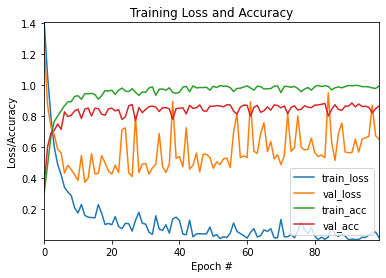

In [22]:
plot_loss_acc(hist)

In [23]:
#model.save_weights('model_1.h5')


Experimentemos o seguinte modelo:

**Modelo 2**
*   1 camada escondida (neurónios: 10, ativação: relu)
*   1 camada output (neurónios: 4, ativação: softmax)



In [109]:
keras.backend.clear_session()
model = keras.Sequential([
  keras.layers.Flatten(),
  keras.layers.Dense(6,activation='relu'),
  keras.layers.Dense(6,activation='relu'),
  keras.layers.Dense(4,activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(training_data_images,training_data_labels,validation_data=(validation_data_images,validation_data_labels),epochs=100,batch_size=16)

Epoch 1/100
75/75 [==============================] - 0s 4ms/step - loss: 1.3999 - accuracy: 0.2617 - val_loss: 1.3718 - val_accuracy: 0.2912
Epoch 2/100
75/75 [==============================] - 0s 3ms/step - loss: 1.3436 - accuracy: 0.3317 - val_loss: 1.2781 - val_accuracy: 0.4600
Epoch 3/100
75/75 [==============================] - 0s 3ms/step - loss: 1.1752 - accuracy: 0.4725 - val_loss: 1.1262 - val_accuracy: 0.4812
Epoch 4/100
75/75 [==============================] - 0s 3ms/step - loss: 0.9155 - accuracy: 0.6025 - val_loss: 0.9491 - val_accuracy: 0.5375
Epoch 5/100
75/75 [==============================] - 0s 3ms/step - loss: 0.7738 - accuracy: 0.6625 - val_loss: 0.7564 - val_accuracy: 0.7013
Epoch 6/100
75/75 [==============================] - 0s 3ms/step - loss: 0.7050 - accuracy: 0.6942 - val_loss: 0.7308 - val_accuracy: 0.6913
Epoch 7/100
75/75 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.7050 - val_loss: 0.7026 - val_accuracy: 0.6800
Epoch 8/100
7

In [110]:
print_loss_acc(hist)

[('loss', 0.022409779950976372), ('accuracy', 0.9941666722297668), ('val_loss', 1.0084083080291748), ('val_accuracy', 0.8025000095367432)]


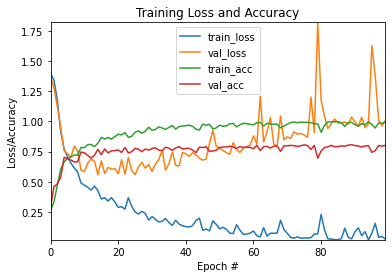

In [111]:
plot_loss_acc(hist)

In [112]:
model.save_weights('model_2.h5')

Modelo 3:

In [116]:
keras.backend.clear_session()
model = keras.Sequential([
  keras.layers.Flatten(),
  keras.layers.Dense(7,activation='relu'),
  keras.layers.Dense(4,activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(training_data_images,training_data_labels,validation_data=(validation_data_images,validation_data_labels),epochs=100,batch_size=16)

Epoch 1/100
75/75 [==============================] - 0s 4ms/step - loss: 1.3812 - accuracy: 0.3392 - val_loss: 1.2948 - val_accuracy: 0.3425
Epoch 2/100
75/75 [==============================] - 0s 3ms/step - loss: 1.2305 - accuracy: 0.4450 - val_loss: 1.1906 - val_accuracy: 0.4850
Epoch 3/100
75/75 [==============================] - 0s 3ms/step - loss: 1.1685 - accuracy: 0.4850 - val_loss: 1.1646 - val_accuracy: 0.5100
Epoch 4/100
75/75 [==============================] - 0s 3ms/step - loss: 1.1340 - accuracy: 0.4842 - val_loss: 1.1175 - val_accuracy: 0.5188
Epoch 5/100
75/75 [==============================] - 0s 3ms/step - loss: 1.1008 - accuracy: 0.5067 - val_loss: 1.1205 - val_accuracy: 0.4663
Epoch 6/100
75/75 [==============================] - 0s 2ms/step - loss: 1.0689 - accuracy: 0.5175 - val_loss: 1.0674 - val_accuracy: 0.5537
Epoch 7/100
75/75 [==============================] - 0s 3ms/step - loss: 1.0472 - accuracy: 0.5475 - val_loss: 1.0458 - val_accuracy: 0.5450
Epoch 8/100
7

In [117]:
print_loss_acc(hist)

[('loss', 0.4782267212867737), ('accuracy', 0.8141666650772095), ('val_loss', 0.8093924522399902), ('val_accuracy', 0.6337500214576721)]


In [118]:
model.save_weights('model_3.h5')

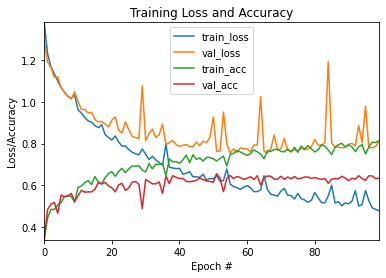

In [119]:
plot_loss_acc(hist)

Carregemos os pesos do modelo 1.

In [123]:
keras.backend.clear_session()
model = keras.Sequential([
  keras.layers.Flatten(),
  keras.layers.Dense(10,activation='relu'),
  keras.layers.Dense(10,activation='relu'),
  keras.layers.Dense(4,activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(training_data_images,training_data_labels,validation_data=(validation_data_images,validation_data_labels),epochs=1,batch_size=16)

75/75 [==============================] - 0s 5ms/step - loss: 1.3444 - accuracy: 0.3492 - val_loss: 1.1794 - val_accuracy: 0.4412


In [124]:
model.load_weights('model_1.h5')

In [126]:
np.set_printoptions(threshold=np.inf)


[1 0 3 3 0 2 3 3 0 3 0 3 0 1 1 0 1 0 0 1 1 1 0 1 0 1 2 0 0 1 0 0 3 1 1 3 0
 3 0 3 2 0 3 0 2 2 2 3 2 0 0 3 0 0 1 3 2 2 1 1 0 3 3 3 1 1 3 0 1 1 3 1 3 2
 1 3 1 3 3 0 3 0 0 3 0 0 0 1 3 2 3 0 2 0 3 0 0 2 3 3 1 2 0 0 1 3 3 2 2 2 1
 3 0 0 3 2 2 3 3 1 1 1 0 1 3 1 3 3 3 2 2 1 2 0 0 0 1 1 0 3 3 0 2 3 2 1 1 1
 3 3 0 0 1 2 2 1 2 1 1 3 2 2 0 1 1 2 1 2 2 0 0 1 0 0 1 2 3 1 3 2 2 1 1 1 1
 0 1 2 1 2 3 1 2 1 2 0 2 2 2 3 3 0 2 3 3 1 3 1 0 2 2 2 1 2 2 3 1 2 0 3 2 2
 1 3 0 1 0 2 3 3 3 3 2 2 3 1 3 0 0 3 2 2 3 3 2 1 2 1 3 2 2 0 2 0 2 2 3 2 2
 0 3 1 3 0 2 1 0 3 2 3 1 1 1 2 0 0 0 2 3 0 1 0 0 1 3 0 1 3 1 2 0 1 1 1 1 3
 0 2 3 0 0 2 0 3 3 1 2 1 0 1 2 2 2 1 1 2 3 3 2 1 1 2 1 2 2 1 2 3 0 2 3 3 1
 1 1 3 1 3 2 1 3 2 1 3 1 1 0 3 2 1 1 3 2 3 3 0 2 3 2 1 0 0 0 0 3 1 2 2 0 2
 2 0 2 2 2 2 2 3 1 0 2 1 1 3 1 1 1 1 0 0 0 2 1 3 0 3 2 0 1 0 2 1 0 1 2 0 0
 2 0 2 2 0 3 0 3 0 1 3 1 2 2 2 2 0 1 1 0 1 3 1 3 2 0 2 2 2 3 3 0 3 3 0 2 2
 2 1 1 1 0 1 1 3 3 1 2 1 1 1 2 3 0 3 3 0 1 1 0 2 3 1 2 3 0 0 1 3 2 2 1 0 2
 0 0 3 2 3 0 1 2 0 2 3 3 

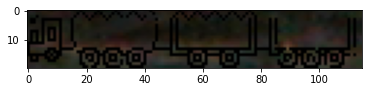

In [134]:
_print_predictions_example(model,'rW0Z2KW34l53Igx7l6Kt.npz')
_visualize_predictions_example(model, 'rW0Z2KW34l53Igx7l6Kt.npz',10)